In [1]:
import os
import sv as SV
import numpy as np
import astropy.table as atable
from tqdm.notebook import tqdm, trange

from desiutil.dust import mwdust_transmission, ext_odonnell
from desitarget.sv1.sv1_targetmask import bgs_mask as sv1_bgs_mask
from desitarget.sv3.sv3_targetmask import bgs_mask as sv3_bgs_mask

In [2]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
# load compiled zsuccess rates to file
#dat_dir = '/global/cscratch1/sd/chahah/bgs-cmxsv/sv-paper/'
dat_dir = '/Users/chahah/data/bgs_cmxsv/sv_paper/'

sv1_gals = atable.Table.read(os.path.join(dat_dir, 'sv1.bgs_exps.efftime160_200.zsuccess.fits'))
sv3_gals = atable.Table.read(os.path.join(dat_dir, 'sv3.bgs_exps.efftime160_200.zsuccess.fits'))
main_gals = atable.Table.read(os.path.join(dat_dir, 'main.bgs_exps.efftime160_200.zsuccess.fits'))

(0.0, 20.0)

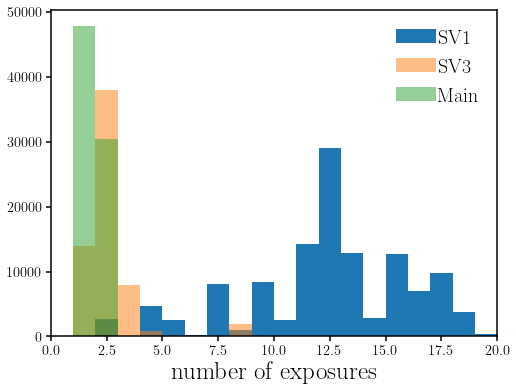

In [4]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)

_ = sub.hist(sv1_gals['DEEP_NUMEXP'], range=(0., 20), bins=20, label='SV1')
_ = sub.hist(sv3_gals['DEEP_NUMEXP'], range=(0., 20), bins=20, alpha=0.5, label='SV3')
_ = sub.hist(main_gals['DEEP_NUMEXP'], range=(0., 20), bins=20, alpha=0.5, label='Main')

sub.legend(loc='upper right', handletextpad=0.1, fontsize=20)
sub.set_xlabel('number of exposures', fontsize=25)
sub.set_xlim(0., 20)

## calculate MW transmission

In [5]:
sv1_gals = sv1_gals[(sv1_gals['PHOTSYS'] != '') & (sv1_gals['PHOTSYS'] != 'G')]
sv3_gals = sv3_gals[sv3_gals['PHOTSYS'] != '']

In [6]:
from speclite import filters
decamwise = filters.load_filters('decam2014-g', 'decam2014-r','decam2014-z', 'wise2010-W1', 'wise2010-W2')
bassmzlswise = filters.load_filters('BASS-g', 'BASS-r', 'MzLS-z','wise2010-W1', 'wise2010-W2')

In [7]:
RV = 3.1

In [8]:
sv1_mw_trans = np.array([10**(-0.4 * sv1_gals['EBV'][i] * RV * ext_odonnell(bassmzlswise.effective_wavelengths.value, Rv=RV)) if sv1_gals['PHOTSYS'][i] == 'N'
                         else 10**(-0.4 * sv1_gals['EBV'][i] * RV * ext_odonnell(decamwise.effective_wavelengths.value, Rv=RV)) for i in range(len(sv1_gals['EBV']))])

In [9]:
sv3_mw_trans = np.array([10**(-0.4 * sv3_gals['EBV'][i] * RV * ext_odonnell(bassmzlswise.effective_wavelengths.value, Rv=RV)) if sv3_gals['PHOTSYS'][i] == 'N'
                         else 10**(-0.4 * sv3_gals['EBV'][i] * RV * ext_odonnell(decamwise.effective_wavelengths.value, Rv=RV)) for i in range(len(sv3_gals['EBV']))])

In [10]:
sv1_deep = (sv1_gals['DEEP_EXPTIME'] > 2000)
sv1_gmag = 22.5 - 2.5 * np.log10((sv1_gals['FLUX_G']/sv1_mw_trans[:,0]).clip(1e-16))
sv1_rmag = 22.5 - 2.5 * np.log10((sv1_gals['FLUX_R']/sv1_mw_trans[:,1]).clip(1e-16))
sv1_zmag = 22.5 - 2.5 * np.log10((sv1_gals['FLUX_Z']/sv1_mw_trans[:,2]).clip(1e-16))
sv1_rfib = 22.5 - 2.5 * np.log10((sv1_gals['FIBERFLUX_R']/sv1_mw_trans[:,1]).clip(1e-16))
sv1_w1   = 22.5 - 2.5 * np.log10((sv1_gals['FLUX_W1']/sv1_mw_trans[:,3]).clip(1e-16))
sv1_brgt = (sv1_gals['SV1_BGS_TARGET'] & sv1_bgs_mask['BGS_BRIGHT']) != 0 
sv1_lowq = (sv1_gals['SV1_BGS_TARGET'] & sv1_bgs_mask['BGS_LOWQ']) != 0 
sv1_fain = (sv1_gals['SV1_BGS_TARGET'] & sv1_bgs_mask['BGS_FAINT']) != 0

sv3_deep = (sv3_gals['DEEP_NUMEXP'] > 2)
print(np.sum(sv3_deep))
sv3_gmag = 22.5 - 2.5 * np.log10((sv3_gals['FLUX_G']/sv3_mw_trans[:,0]).clip(1e-16))
sv3_rmag = 22.5 - 2.5 * np.log10((sv3_gals['FLUX_R']/sv3_mw_trans[:,1]).clip(1e-16))
sv3_zmag = 22.5 - 2.5 * np.log10((sv3_gals['FLUX_Z']/sv3_mw_trans[:,2]).clip(1e-16))
sv3_rfib = 22.5 - 2.5 * np.log10((sv3_gals['FIBERFLUX_R']/sv3_mw_trans[:,1]).clip(1e-16))
sv3_w1   = 22.5 - 2.5 * np.log10((sv3_gals['FLUX_W1']/sv3_mw_trans[:,3]).clip(1e-16))
sv3_brgt = (sv3_gals['SV3_BGS_TARGET'] & sv3_bgs_mask['BGS_BRIGHT']) != 0 
sv3_fain = (sv3_gals['SV3_BGS_TARGET'] & sv3_bgs_mask['BGS_FAINT']) != 0 

10606


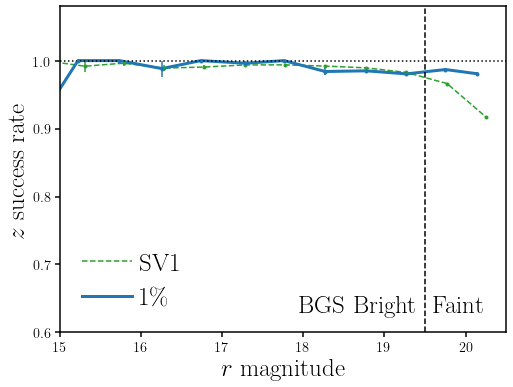

In [11]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)

rmid, zsrate, err_zsrate = SV.zsuccess_rate(sv1_rmag[sv1_deep & ~sv1_lowq], sv1_gals['ZSUCCESS'][sv1_deep & ~sv1_lowq], range=(12, 22), nbins=20)
sub.errorbar(rmid, zsrate, yerr=err_zsrate, fmt='.C2')
sub.plot(rmid, zsrate, c='C2', ls='--', label='SV1')

rmid, zsrate, err_zsrate = SV.zsuccess_rate(sv3_rmag[sv3_deep], sv3_gals['ZSUCCESS'][sv3_deep], range=(12, 22), nbins=20)
sub.errorbar(rmid, zsrate, yerr=err_zsrate, fmt='.C0')
sub.plot(rmid, zsrate, c='C0', lw=3, label='$1\%$')

sub.axhline(1., color='k', linestyle=':')
sub.axvline(19.5, color='k', linestyle='--')
sub.text(19.4, 0.63, 'BGS Bright', ha='right', fontsize=25, rotation=0)
sub.text(19.6, 0.63, 'Faint', ha='left', fontsize=25, rotation=0)

sub.legend(loc='lower left', fontsize=25, handletextpad=0.3)
sub.set_xlabel('$r$ magnitude', fontsize=25)
sub.set_xlim(15, 20.5)
sub.set_ylabel('$z$ success rate', fontsize=25)
sub.set_ylim(0.6, 1.08)

fig.savefig('figs/zsuccess_rmag.pdf', bbox_inches='tight')

(16.0, 26.0)

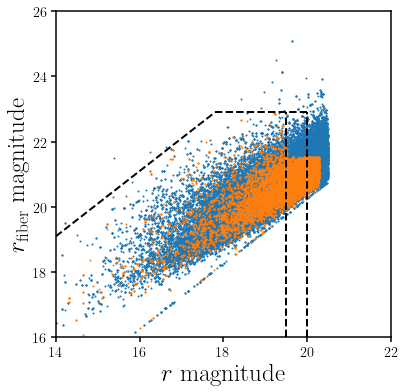

In [12]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)

sub.scatter(sv1_rmag[sv1_deep & ~sv1_lowq], sv1_rfib[sv1_deep & ~sv1_lowq], c='C0', s=1)
sub.scatter(sv3_rmag[sv3_deep], sv3_rfib[sv3_deep], c='C1', s=1)

sub.plot([14, 17.8], [19.1, 22.9], c='k', ls='--', lw=2)
sub.plot([17.8, 20.0], [22.9, 22.9], c='k', ls='--', lw=2)
sub.plot([19.5, 19.5], [16., 22.9], c='k', ls='--', lw=2)
sub.plot([20., 20.], [16., 22.9], c='k', ls='--', lw=2)

sub.set_xlabel('$r$ magnitude', fontsize=25)
sub.set_xlim(14, 22)
sub.set_ylabel(r'$r_{\rm fiber}$ magnitude', fontsize=25)
sub.set_ylim(16, 26)

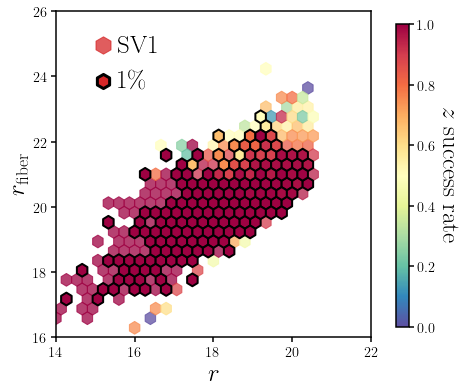

In [13]:
fig = plt.figure(figsize=(7,6))
sub = fig.add_subplot(111)

hb = sub.hexbin(sv1_rmag[sv1_deep & ~sv1_lowq], sv1_rfib[sv1_deep & ~sv1_lowq], C=sv1_gals['ZSUCCESS'][sv1_deep & ~sv1_lowq].astype(float), 
                reduce_C_function=np.mean, extent=(14, 22, 16, 26), gridsize=30, vmin=0., vmax=1., mincnt=2, cmap='Spectral_r', 
                alpha=0.75)

hb = sub.hexbin(sv3_rmag[sv3_deep], sv3_rfib[sv3_deep], C=sv3_gals['ZSUCCESS'][sv3_deep].astype(float), edgecolors='k', linewidth=2.,
                reduce_C_function=np.mean, extent=(14, 22, 16, 26), gridsize=30, vmin=0., vmax=1., mincnt=2, cmap='Spectral_r')

sub.scatter([], [], marker='h', s=300, label='SV1', c='C3', alpha=0.75)
sub.scatter([], [], marker='h', s=200, label='$1\%$', linewidth=3, c='C3', edgecolor='k')

sub.legend(loc='upper left', fontsize=25, handletextpad=-0.4)
#sub.text(14.5, 20.3, 'fiber-magnitude cut', rotation=39, fontsize=15)
#sub.plot([14, 17.8], [19.1, 22.9], c='k', ls='--', lw=3)
#sub.plot([17.8, 20.0], [22.9, 22.9], c='k', ls='--', lw=3)
#sub.plot([20., 22.], [22.9, 24.9], c='k', ls='--', lw=3)

#sub.plot([19.5, 19.5], [16., 22.9], c='k', ls='--', lw=2)
#sub.plot([20., 20.], [16., 22.9], c='k', ls='--', lw=2)

sub.set_xlabel('$r$', fontsize=25)
sub.set_xlim(14, 22)
sub.set_ylabel(r'$r_{\rm fiber}$', fontsize=25)
sub.set_ylim(16, 26)

fig.subplots_adjust(wspace=0.1, right=0.75)

cbar_ax = fig.add_axes([0.8, 0.15, 0.025, 0.7])
cbar = fig.colorbar(hb, cax=cbar_ax)
cbar.ax.set_ylabel(r'$z$ success rate', labelpad=25, fontsize=25, rotation=270)
fig.savefig('figs/zsuccess_rmag_rfib.pdf', bbox_inches='tight')

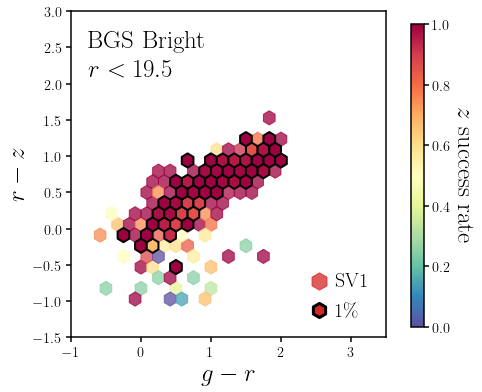

In [14]:
fig = plt.figure(figsize=(7,6))
sub = fig.add_subplot(111)

hb = sub.hexbin((sv1_gmag - sv1_rmag)[sv1_deep & sv1_brgt], (sv1_rmag - sv1_zmag)[sv1_deep & sv1_brgt], C=sv1_gals['ZSUCCESS'][sv1_deep & sv1_brgt].astype(float), 
                reduce_C_function=np.mean, extent=(-1, 4, -2, 3), gridsize=30, vmin=0., vmax=1., mincnt=2,
                cmap='Spectral_r', alpha=0.75)

hb = sub.hexbin((sv3_gmag - sv3_rmag)[sv3_deep & sv3_brgt], (sv3_rmag - sv3_zmag)[sv3_deep & sv3_brgt], C=sv3_gals['ZSUCCESS'][sv3_deep & sv3_brgt].astype(float), 
                reduce_C_function=np.mean, extent=(-1, 4, -2, 3), gridsize=30, vmin=0., vmax=1., mincnt=2, 
                cmap='Spectral_r', edgecolors='k', linewidth=2.)

sub.scatter([], [], marker='h', s=300, label='SV1', c='C3', alpha=0.75)
sub.scatter([], [], marker='h', s=200, label='$1\%$', linewidth=3, c='C3', edgecolor='k')

sub.text(-0.75, 2.5, r'BGS Bright', fontsize=25)
sub.text(-0.75, 2.1, r'$r < 19.5$', fontsize=25)
sub.legend(loc='lower right', fontsize=20, handletextpad=-0.2)

sub.set_xlabel('$g - r$', fontsize=25)
sub.set_xlim(-1, 3.5)
sub.set_ylabel(r'$r - z$', fontsize=25)
sub.set_ylim(-1.5, 3)

fig.subplots_adjust(wspace=0.1, right=0.75)

cbar_ax = fig.add_axes([0.8, 0.15, 0.025, 0.7])
cbar = fig.colorbar(hb, cax=cbar_ax)
cbar.ax.set_ylabel(r'$z$ success rate', labelpad=25, fontsize=25, rotation=270)
fig.savefig('figs/zsuccess_gr_rz.pdf', bbox_inches='tight')

In [15]:
sv1_fibcol = (sv1_zmag - sv1_w1) - 3/2.5 * (sv1_gmag - sv1_rmag) + 1.2
sv3_fibcol = (sv3_zmag - sv3_w1) - 3/2.5 * (sv3_gmag - sv3_rmag) + 1.2

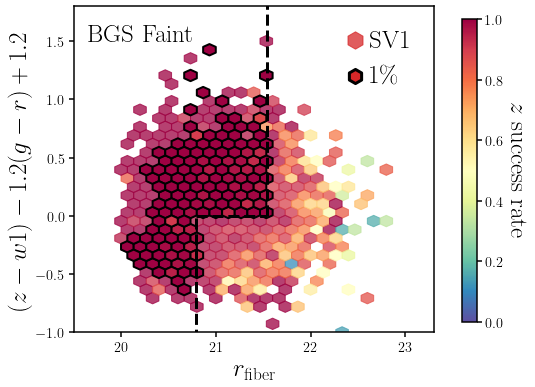

In [16]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)

hb = sub.hexbin(sv1_rfib[sv1_deep & sv1_fain], sv1_fibcol[sv1_deep & sv1_fain], C=sv1_gals['ZSUCCESS'][sv1_deep & sv1_fain].astype(float),
                reduce_C_function=np.mean, extent=(19., 23., -1., 1.5), gridsize=30, vmin=0., vmax=1., mincnt=5,
                cmap='Spectral_r', alpha=0.75)

hb = sub.hexbin(sv3_rfib[sv3_deep & sv3_fain], sv3_fibcol[sv3_deep & sv3_fain], C=sv3_gals['ZSUCCESS'][sv3_deep & sv3_fain].astype(float),
                reduce_C_function=np.mean, extent=(19., 23., -1., 1.5), gridsize=30, vmin=0., vmax=1., mincnt=5,
                cmap='Spectral_r', edgecolors='k', linewidth=2.)

sub.scatter([], [], marker='h', s=300, label='SV1', c='C3', alpha=0.75)
sub.scatter([], [], marker='h', s=200, label='$1\%$', linewidth=3, c='C3', edgecolor='k')

sub.plot([20.79, 20.79], [-2, 0.], c='k', ls='--', lw=3)
sub.plot([20.79, 21.54], [0., 0.], c='k', ls='--', lw=3)
sub.plot([21.54, 21.54], [0., 2.], c='k', ls='--', lw=3)

sub.legend(loc='upper right', fontsize=25, handletextpad=-0.4)
sub.text(19.65, 1.5, r'BGS Faint', fontsize=25)

sub.set_ylabel('$(z - w1) - 1.2 (g - r) + 1.2$', fontsize=25)
sub.set_yticks([-1., -0.5, 0., 0.5, 1., 1.5])
sub.set_ylim(-1., 1.8)
sub.set_xlabel(r'$r_{\rm fiber}$', fontsize=25)
sub.set_xlim(19.5, 23.3)
sub.set_xticks([20, 21, 22, 23])

fig.subplots_adjust(wspace=0.1, right=0.75)

cbar_ax = fig.add_axes([0.8, 0.15, 0.025, 0.7])
cbar = fig.colorbar(hb, cax=cbar_ax)
cbar.ax.set_ylabel(r'$z$ success rate', labelpad=25, fontsize=25, rotation=270)
fig.savefig('figs/zsuccess_rfib_col.pdf', bbox_inches='tight')